# 격자 자료 (수치예보모델 분석장) 활용
- 미국의 GFS 모델 자료 활용
- https://www.ncdc.noaa.gov/data-access/model-data/model-datasets/global-forcast-system-gfs 에서 자료 받을 수 있음
- grib 파일로, .grb2 확장자를 사용하고 있음
- 예시로 사용한 파일은 위,경도가 1도 간격의 분석장
- xarray라는 패키지를 이용해 grib 파일을 읽고 처리할 수 있음 (metpy와 함께 설치됨)
- cfgrib이라는 패키지를 추가로 설치해주어야 함 (conda install -c conda-forge cfgrib)
- ECCODES_DEFINITION_PATH'를 'C:\Users\DongGyu_Hyeon\miniconda3\Library\share\eccodes\definitions'로 설정해야 함
- Windows 10 사용자: 내PC > 고급시스템설정 > 환경변수 > 시스템변수 > 새로만들기 (이미 있다면 할 필요 없음)
- C:\Users\DongGyu_Hyeon\miniconda3\이 부분은 본인의 경로에 맞게 고쳐주세요
- 아래 코드는 https://unidata.github.io/python-training/gallery/500hpa_hght_winds/ 와 
- https://unidata.github.io/python-training/gallery/upperair_obs/ 참조

In [1]:
from datetime import datetime

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
from metpy.units import units
import numpy as np
from scipy.ndimage import gaussian_filter
import xarray as xr
import cfgrib


In [11]:
def plot_maxmin_points(lon, lat, data, extrema, nsize, symbol, color='k',
                       plotValue=True, transform=None):
    """
    This function will find and plot relative maximum and minimum for a 2D grid. The function
    can be used to plot an H for maximum values (e.g., High pressure) and an L for minimum
    values (e.g., low pressue). It is best to used filetered data to obtain  a synoptic scale
    max/min value. The symbol text can be set to a string value and optionally the color of the
    symbol and any plotted value can be set with the parameter color.

    Parameters
    ----------
        lon : 2D array
            Plotting longitude values
        lat : 2D array
            Plotting latitude values
        data : 2D array
            Data that you wish to plot the max/min symbol placement
        extrema : str
            Either a value of max for Maximum Values or min for Minimum Values
        nsize : int
            Size of the grid box to filter the max and min values to plot a reasonable number
        symbol : str
            Text to be placed at location of max/min value
        color : str
            Name of matplotlib colorname to plot the symbol (and numerical value, if plotted)
        plot_value : Boolean (True/False)
            Whether to plot the numeric value of max/min point

    Return
    ------
        The max/min symbol will be plotted on the current axes within the bounding frame
        (e.g., clip_on=True)
    """
    from scipy.ndimage.filters import maximum_filter, minimum_filter

    if (extrema == 'max'):
        data_ext = maximum_filter(data, nsize, mode='nearest')
    elif (extrema == 'min'):
        data_ext = minimum_filter(data, nsize, mode='nearest')
    else:
        raise ValueError('Value for hilo must be either max or min')

    if lon.ndim == 1:
        lon, lat = np.meshgrid(lon, lat)

    mxx, mxy = np.where(data_ext == data)

    for i in range(len(mxy)):
        ax.text(lon[mxx[i], mxy[i]], lat[mxx[i], mxy[i]], symbol, color=color, size=36,
                clip_on=True, horizontalalignment='center', verticalalignment='center',
                transform=transform)
        ax.text(lon[mxx[i], mxy[i]], lat[mxx[i], mxy[i]],
                '\n' + str(np.int32(data[mxx[i], mxy[i]])),
                color=color, size=12, clip_on=True, fontweight='bold',
                horizontalalignment='center', verticalalignment='top', transform=transform)
        ax.plot(lon[mxx[i], mxy[i]], lat[mxx[i], mxy[i]], marker='o', markeredgecolor='black',
                markerfacecolor='white', transform=transform)
        ax.plot(lon[mxx[i], mxy[i]], lat[mxx[i], mxy[i]],
                marker='x', color='black', transform=transform)

# 지상일기도

In [7]:
ds2 = xr.open_dataset(r'C:\Users\DongGyu_Hyeon\gfs_3_20210921_0000_000.grb2',
                      engine='cfgrib',backend_kwargs={'filter_by_keys':{'typeOfLevel': 'meanSea'},'indexpath': ''})
ds2

<xarray.Dataset>
Dimensions:     (latitude: 181, longitude: 360)
Coordinates:
    time        datetime64[ns] ...
    step        timedelta64[ns] ...
    meanSea     float64 ...
  * latitude    (latitude) float64 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * longitude   (longitude) float64 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
    valid_time  datetime64[ns] ...
Data variables:
    prmsl       (latitude, longitude) float32 ...
    mslet       (latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP 
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP 
    history:                 2021-10-01T09:44 GRIB to CDM+CF via cfgrib-0.9.9...

In [8]:
# Select and grab data, at/lon values 
pres = ds2['prmsl'].sel(latitude=slice(90,0), longitude=slice(60,201))
lats = pres.latitude.data
lons = pres.longitude.data

# Select and grab surface pressure, smooth with gaussian_filter
pres = gaussian_filter(pres.data, sigma=3.0) / 100. * units('hPa')

# Create a clean datetime object for plotting based on time of Geopotential heights
dt = datetime(2020, 9, 27, 0)
vtime = datetime.strptime(str(ds2.time.data.astype('datetime64[ms]')),
                          '%Y-%m-%dT%H:%M:%S.%f')

In [9]:
ds2.time.data.astype('datetime64[ms]')

numpy.datetime64('2021-09-21T00:00:00.000')

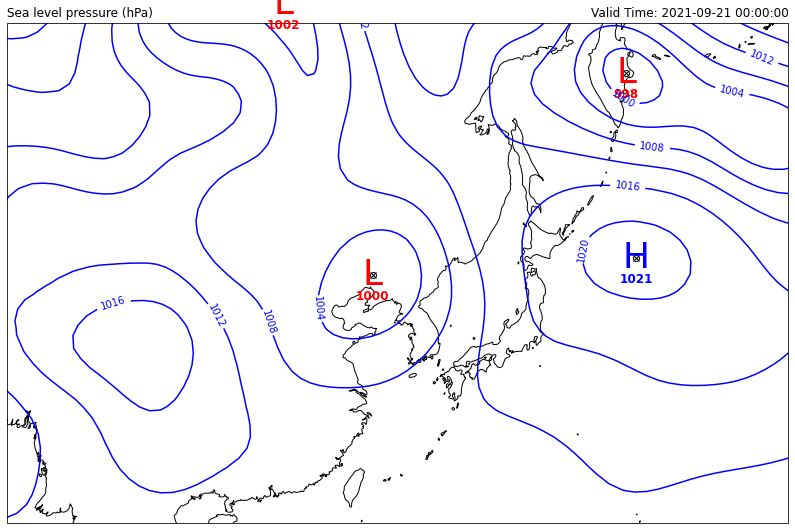

In [12]:
# Set up the projection that will be used for plotting
mapcrs = ccrs.EquidistantConic(central_longitude=125,
                               central_latitude=35,
                               standard_parallels=(30, 60))

# Set up the projection of the data; if lat/lon then PlateCarree is what you want
datacrs = ccrs.PlateCarree()

# Start the figure and create plot axes with proper projection
fig = plt.figure(1, figsize=(14, 12))
ax = plt.subplot(111, projection=mapcrs)
ax.set_extent([90, 160, 20, 60], ccrs.PlateCarree())

# Add geopolitical boundaries for map reference
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.STATES.with_scale('50m'))

# Plot surface pressure in hPa
clevs_pres = np.arange(860, 1100, 4)
cs = ax.contour(lons, lats, pres.to('hPa'), clevs_pres, colors='blue', 
                transform=datacrs)
plt.clabel(cs, fmt='%d')

# Use definition to plot H/L symbols
plot_maxmin_points(lons, lats, pres.m, 'max', 50,
                   symbol='H', color='blue', transform=ccrs.PlateCarree())
plot_maxmin_points(lons, lats, pres.m, 'min', 25,
                   symbol='L', color='red', transform=ccrs.PlateCarree())

# Make some nice titles for the plot (one right, one left)
plt.title('Sea level pressure (hPa)',
           loc='left')
plt.title('Valid Time: {}'.format(vtime), loc='right')

# Adjust image and show
plt.subplots_adjust(bottom=0, top=1)

# 상층일기도 (500hPa)

In [13]:
levels = (850, 700, 500, 300, 200)
ds = xr.open_dataset(r'C:\Users\DongGyu_Hyeon\gfs_3_20210921_0000_000.grb2'
                    , engine='cfgrib',backend_kwargs={'filter_by_keys':{'typeOfLevel': 'isobaricInhPa', 'level':500}})
ds

<xarray.Dataset>
Dimensions:        (latitude: 181, longitude: 360)
Coordinates:
    time           datetime64[ns] ...
    step           timedelta64[ns] ...
    isobaricInhPa  float64 ...
  * latitude       (latitude) float64 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * longitude      (longitude) float64 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
    valid_time     datetime64[ns] ...
Data variables: (12/16)
    gh             (latitude, longitude) float32 ...
    t              (latitude, longitude) float32 ...
    r              (latitude, longitude) float32 ...
    tcc            (latitude, longitude) float32 ...
    q              (latitude, longitude) float32 ...
    w              (latitude, longitude) float32 ...
    ...             ...
    clwmr          (latitude, longitude) float32 ...
    icmr           (latitude, longitude) float32 ...
    rwmr           (latitude, longitude) float32 ...
    snmr           (latitude, longitude) float32 ...
    grle           (latitude, longitude) float32 ...
    o3mr           (latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP 
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP 
    history:                 2021-10-01T09:49 GRIB to CDM+CF via cfgrib-0.9.9...

In [14]:
# Select and grab data
hght = ds['gh'].sel(latitude=slice(90,0), longitude=slice(60,201))
uwnd = ds['u'].sel(latitude=slice(90,0), longitude=slice(60,201))
vwnd = ds['v'].sel(latitude=slice(90,0), longitude=slice(60,201))
temp = ds['t'].sel(latitude=slice(90,0), longitude=slice(60,201))
lats = hght.latitude.data
lons = hght.longitude.data

# Select and grab 500-hPa geopotential heights and wind components, smooth with gaussian_filter
hght_500 = gaussian_filter(hght.data, sigma=3.0)
uwnd_500 = gaussian_filter(uwnd.data, sigma=3.0) * units('m/s')
vwnd_500 = gaussian_filter(vwnd.data, sigma=3.0) * units('m/s')
temp_500 = gaussian_filter(temp.data, sigma=3.0) * units('K')

# Use MetPy to calculate the wind speed for colorfill plot, change units to knots from m/s
sped_500 = mpcalc.wind_speed(uwnd_500, vwnd_500).to('kt')

# Create a clean datetime object for plotting based on time of Geopotential heights
dt = datetime(2020, 9, 27, 0)
vtime = datetime.strptime(str(ds.time.data.astype('datetime64[ms]')),
                          '%Y-%m-%dT%H:%M:%S.%f')

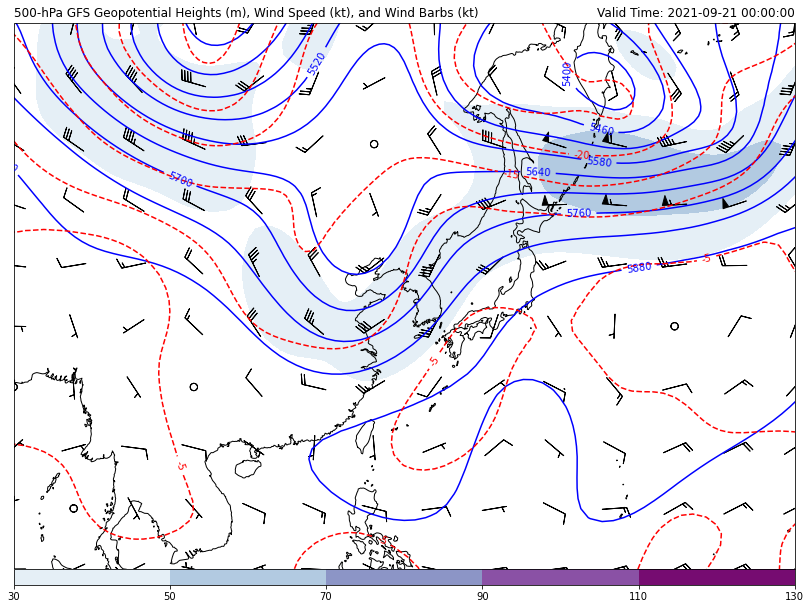

In [15]:
# Set up the projection that will be used for plotting
mapcrs = ccrs.EquidistantConic(central_longitude=125,
                               central_latitude=35,
                               standard_parallels=(30, 60))

# Set up the projection of the data; if lat/lon then PlateCarree is what you want
datacrs = ccrs.PlateCarree()

# Start the figure and create plot axes with proper projection
fig = plt.figure(1, figsize=(14, 12))
ax = plt.subplot(111, projection=mapcrs)
ax.set_extent([90, 160, 10, 60], ccrs.PlateCarree())

# Add geopolitical boundaries for map reference
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.STATES.with_scale('50m'))

# Plot 500-hPa Colorfill Wind Speeds in knots
clevs_500_sped = np.arange(30, 150, 20)
cf = ax.contourf(lons, lats, sped_500, clevs_500_sped, cmap=plt.cm.BuPu,
                 transform=datacrs)
plt.colorbar(cf, orientation='horizontal', pad=0, aspect=50)

# Plot 500-hPa Geopotential Heights in meters
clevs_500_hght = np.arange(0, 8000, 60)
cs = ax.contour(lons, lats, hght_500, clevs_500_hght, colors='blue', 
                transform=datacrs)
plt.clabel(cs, fmt='%d')

# Plot 500-hPa Geopotential Heights in meters
clevs_500_temp = np.arange(-30, 5, 5)
cs = ax.contour(lons, lats, temp_500.to('degC'), clevs_500_temp, colors='red', 
                transform=datacrs)
plt.clabel(cs, fmt='%d')

# Plot 500-hPa wind barbs in knots, regrid to reduce number of barbs
ax.barbs(lons, lats, uwnd_500.to('kt').m, vwnd_500.to('kt').m, pivot='middle',regrid_shape=10, 
         color='black',  transform=datacrs)

# Make some nice titles for the plot (one right, one left)
plt.title('500-hPa GFS Geopotential Heights (m), Wind Speed (kt),'
          ' and Wind Barbs (kt)', loc='left')
plt.title('Valid Time: {}'.format(vtime), loc='right')

# Adjust image and show
plt.subplots_adjust(bottom=0, top=1)

# 과제 1
# 기한: 2021년 10월 15일 금요일
# 제출은 추후 eTL을 통해 제출
# station_plot과 griddata_plot 예시를 합하여 지상일기도 분석
- 시각은 각자 원하는 때로 하고, 우리나라가 지도 중심에 오도록 동아시아 지상일기도를 작성해주세요.
- 관측자료는 운량, 바람, 해면기압, 기온, 이슬점온도가 포함되도록 해주세요.
- 등압선은 격자 자료(GFS 분석장이나 ERA5 재분석장 자료)를 사용해주세요.
- 그린 지상일기도를 넣고 기압 배치와 우리나라의 기상 개황을 한 문단으로 정리한 보고서를 작성해주세요.
- 보고서(한글이나 word), 소스코드(.ipynb나 .py)와 사용한 자료(관측, 격자)를 '대기분석_과제1_이름.zip'으로 압축해 제출해주세요.